In [1]:
# import modules
import numpy as np
import math
import copy
import matplotlib.pyplot as plt
from itertools import *
from datetime import datetime, date
import logging
import pickle
from operator import itemgetter
import itertools

import networkx as nx

from qiskit.result import marginal_counts
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.tools import job_monitor

from qiskit.providers.aer.noise import NoiseModel
from qiskit.quantum_info import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, Aer, execute, IBMQ, assemble
from qiskit.providers.aer import AerSimulator
from qiskit.tools.jupyter import *
from qiskit.visualization import *

import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import *
from qiskit.providers.aer import AerError

In [2]:
# set up logger
logger_ = logging.getLogger()
logger_.setLevel(logging.WARNING)

In [ ]:
#IBMQ.load_account()

In [3]:
# load account for accessing SystemQ One in Ehningen
#IBMQ.disable_account()
IBMQ.enable_account('807285e4f347ace42ec1d9020bd10ba9b708ec43e6394de8efb6ac412427e1a7ac87c1ab91bc7a7ca2ca67f02c708d371243234a58021d4017a7e6e223ac30a3', 'https://auth.de.quantum-computing.ibm.com/api')

<AccountProvider for IBMQ(hub='fraunhofer', group='default', project='default')>

In [4]:
# load non-public provider and select backend
IBMQ.providers()

[<AccountProvider for IBMQ(hub='fraunhofer', group='default', project='default')>,
 <AccountProvider for IBMQ(hub='fraunhofer-de', group='fhg-all', project='ticket')>]

In [5]:
#provider = IBMQ.get_provider(project='ticket-ext')
provider = IBMQ.get_provider(project='ticket')
#backend = provider.get_backend('ibmq_ehningen')
#provider.backends()

In [ ]:
def print_backend_info(backend):
    print(backend.name(), end=': ')
    print('simulator: ' + str(backend.configuration().simulator), end=', ')
    print(str(backend.configuration().n_qubits) + ' qubits', end=', ')
    print(str(backend.status().pending_jobs) + ' jobs', end=', ')
    print(backend.status().status_msg, end=', ')
    if 'runtime' in backend.configuration().input_allowed:
        print("supports Runtime: yes")
    else:
        print("supports Runtime: no")

print("Provider:",provider)
print("Infos for available backends:")
for backend in provider.backends():
    print_backend_info(backend)

In [ ]:
print("Filtered backends:")
backends_filtered = provider.backends(
    filters=lambda backend: 
        backend.configuration().n_qubits > 20
        and
        backend.configuration().simulator is False
        and
        backend.status().operational is True
        and
        'runtime' in backend.configuration().input_allowed)

for backend in backends_filtered:
    print_backend_info(backend)

from qiskit.providers.ibmq import least_busy
backend = least_busy(backends_filtered)

print("The least busy backend is " + backend.name())

In [6]:
backend_name = 'ibmq_ehningen' # oder toronto (gleicher Chip, Falcon4)
backend = provider.get_backend(backend_name)

In [ ]:
jobs = backend.jobs(descending=True, status=QUEUED)

In [7]:
# get 'live' configuration and properties 
configuration = backend.configuration()
coupling_map = configuration.coupling_map

noise_model = NoiseModel.from_backend(backend)
basis_gates = noise_model.basis_gates

properties = backend.properties()

Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.066908 > 1.066667). Truncating to maximum value.
Device reported a gate error parameter greater than maximum allowed value (1.000000 > 0.800000). Truncating to maximum value.
Device model returned a depolarizing error parameter greater than maximum allowed value (1.066952 > 1.066667). Truncating to maximum value.


In [ ]:
# dump noise model for later use
pickle_noise_model = [noise_model, configuration, properties]
with open("noisemodel_" + backend_name + str(date.today()) + "23-43-.dat", "bw") as f:
    pickle.dump(pickle_noise_model,f)

In [ ]:
with open("noisemodel_ibmq_ehningen2022-05-27.dat", "br") as f:
    noise_data = pickle.load(f)
    noise_model = noise_data[0]
    configuration = noise_data[1]
    properties = noise_data[2]
coupling_map = configuration.coupling_map
basis_gates = noise_model.basis_gates

In [8]:
def build_noise_model_from_backend():
    single_qubit_gates = ['id', 'sx', 'x']
    two_qubit_gates = ['cx']
    measure_reset = ['reset', 'measure']
    # instantiate model
    my_noise_model = NoiseModel()
    # Build single qubit errors: ich nehme vorläufig die fertigen, dann gleiche ich daran ab. 
    for i in range(configuration.n_qubits):
        t2 = properties.t2(i)
        t1 = properties.t1(i)
        if (t2 >= 2*t1):
            logging.info("t2 of qubit ",i," is too large:", t2)
            t2 = 2*t1
            logging.info("Truncated to :", t2, "\n")
        for gate in single_qubit_gates:
            # get calibrated gate properties from backend
            gateerror = properties.gate_error(gate,i)
            ###################print("gateerror: ", gateerror)
            gatetime = properties.gate_length(gate,i)
            # set up appropriate thermal error
            thermal_error = thermal_relaxation_error(t1=t1, t2=t2, time=gatetime)
            # calc fidelity and difference to total gate error
            fid_therm = average_gate_fidelity(thermal_error)
            logging.info("infidelity thermal error: ", (1-fid_therm))
            fidelity_diff = fid_therm-(1-gateerror)
            # fill up the difference with a depolarizing error
            p_depol = 2*fidelity_diff
            if (p_depol<=0.0):
                p_depol=0
                logging.info(("for qubit {} and gate {} thermal error {} larger than gate error {}. \n")\
                      .format(i,gate, (1-fid_therm),gateerror))
            single_depol_error = depolarizing_error(p_depol,1)
            fid_depol = average_gate_fidelity(single_depol_error)
            ################print("infidelity depol error: ", (1-fid_depol))
            # compose operators, depolarizing error first, followed by thermal relaxation
            total_error = single_depol_error.compose(thermal_error)
            # check if gate fidelity of the model is equal to the measured gate fidelity 
            gate_fidelity = average_gate_fidelity(total_error)
            diff_gateerror = (gateerror-(1-gate_fidelity))
            if abs(diff_gateerror)>=0.000001:
                logging.info("difference of calculated and calibrated gate error: ", diff_gateerror, "\n")

            # add error on ith qubit to error model
            my_noise_model.add_quantum_error(total_error,[gate],[i])

            # compare with build-in model:
            compareerror = Kraus((noise_model.__dict__)['_local_quantum_errors'][gate][str(i)])
            if (1-process_fidelity(Kraus(total_error),compareerror))>=0.00000001:
                logging.info("operator deviation for qubit nr and gate ", i, gate, "\n")
                logging.info(process_fidelity(Kraus(total_error),compareerror))

    # build two-qubit errors:Two-qubit gate errors consisting of a two-qubit depolarizing error followed by single-qubit thermal relaxation errors on both qubits in the gate.
    for pair in coupling_map:
        t2_0 = properties.t2(pair[0])
        t1_0 = properties.t1(pair[0])
        if (t2_0 >= 2*t1_0):
            logging.info("t2 of qubit ", pair[0]," is too large:", t2_0)
            t2_0 = 2*t1_0
            logging.info("Truncated to :", t2_0)
        t2_1 = properties.t2(pair[1])
        t1_1 = properties.t1(pair[1])
        if (t2_1 >= 2*t1_1):
            logging.info("t2 of qubit ",pair[1]," is too large:", t2_1)
            t2_1 = 2*t1_1
            logging.info("Truncated to :", t2_1)
        for gate in two_qubit_gates:
            gateerror = properties.gate_error(gate,pair)
            logging.info(("gateerror {}").format(gateerror))
            gatetime = properties.gate_length(gate,pair)
            thermal_error_0 = thermal_relaxation_error(t1=t1_0, t2=t2_0, time=gatetime)
            thermal_error_1 = thermal_relaxation_error(t1=t1_1, t2=t2_1, time=gatetime)

            # so hat qubit 0 den thermal error 0.
            # Aber ist das auch das erste des Paars, wenn ich dann das paar mit dem two-qubit-quantum error belege?
            thermal_error = thermal_error_0.tensor(thermal_error_1)

            fid_therm = average_gate_fidelity(thermal_error)
            logging.info(("thermal error {}").format(1.0-fid_therm))
            error_diff = gateerror - 1+fid_therm
            logging.info(("error diff {}").format(error_diff))

            # Formel für Fehler nur auf erstem Qubit:
            #p_depol = (5.0/3.0)*error_diff

            # Formel für depol-Fehler auf beiden Qubits:
            p_depol = (4.0/3.0)*error_diff

            if (p_depol<=0.0):
                p_depol=0
                logging.info(("for qubit {} and gate {} thermal error {} larger than gate error {}. \n")\
                      .format(i,gate, (1-fid_therm),gateerror))
            elif (p_depol>=1.0666666666666667):
                logging.info(("for qubit {} and gate {} depolarizing error {} not big enough. Difference is {}. \n")\
                      .format(i,gate, p_depol, (p_depol-1.0666666666666667)))
                p_depol=1.0666666666666667
            # das hier ist die Variante, bei der der depol-Fehler im 4-dim Raum beider Qubits stattfindet
            logging.info(("p_depol {} \n").format(p_depol))
            try:
                double_depol_error = depolarizing_error(p_depol,2)
            except:
                raise

            # hier ist der Fehler nur auf dem Kontrollqubit
            #single_depol_error = depolarizing_error(p_depol,1)
            #no_error = pauli_error([('I', 1.0)])
            #double_depol_error = no_error.tensor(single_depol_error)

            fid_depol = average_gate_fidelity(double_depol_error)

            total_error = double_depol_error.compose(thermal_error)

            # check if gate fidelity of the model is equal to the measured gate fidelity 
            gate_fidelity = average_gate_fidelity(total_error)
            diff_gateerror = (gateerror-(1-gate_fidelity))
            if abs(diff_gateerror)>=0.00000001:
                logging.info("difference of calculated and calibrated gate error: ", diff_gateerror)

            my_noise_model.add_quantum_error(total_error,[gate],pair)

            # compare with build-in model:
            compareerror = Kraus((noise_model.__dict__)['_local_quantum_errors'][gate][str(pair[0])+","+str(pair[1])])
            if (1-process_fidelity(Kraus(total_error),compareerror))>=0.00000001:
                logging.info("operator deviation for qubits and gate ", pair, gate, ": ", 1-process_fidelity(Kraus(total_error),compareerror))
                logging.info("\n")
    # add reset errors
    # get values for each qubit
    for i in range(configuration.n_qubits):
        l = properties.to_dict()['qubits'][i]
        for r in (d['value'] for d in l if d['name']=='prob_meas0_prep1'):
            p01=r
        for r in (d['value'] for d in l if d['name']=='prob_meas1_prep0'):
            p10=r
        prob_list = [[1-p10,p10],[p01,1-p01]]
        ro_error = ReadoutError(prob_list,i)
        my_noise_model.add_readout_error(ro_error,[i])
        
    return my_noise_model

noise_model = build_noise_model_from_backend()

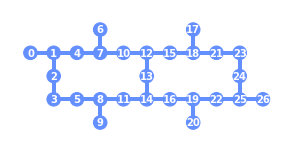

In [9]:
from qiskit.visualization import plot_gate_map
plot_gate_map(backend)

In [10]:
# find all connected subgraphs in coupling map
G = nx.Graph()
G.add_nodes_from(list(np.arange(27)))
G.add_edges_from(coupling_map)

all_connected_subgraphs = []
layout_list = []
nb_nodes=5
for SG in (G.subgraph(selected_nodes) for selected_nodes in combinations(G, nb_nodes)):
    if nx.is_connected(SG):
        #print(SG.nodes)
        all_connected_subgraphs.append(SG)
        cnots = list(SG.edges) + [x[1] for x in (list(itertools.permutations(tup)) for tup in SG.edges)]
        layout_list.append([list(SG.nodes),cnots])
print(len(all_connected_subgraphs))

68


find all maximally connected subgraphs within each layout
the item "cnot_gate_list" specifies the coupling needed for the specific algorithm
so is has to be adapted to the structure of the specific code
counter_cnots counts the number of gate within one layout, so it has to be adapted too

In [11]:
# find all maximally connected subgraphs within each layout
cnot_layout_list = []
for item in layout_list:
    permuts = list(itertools.permutations(item[0]))
    for permut in permuts:
        cnot_gate_list = [(permut[0],permut[3]),(permut[1],permut[0]),(permut[1],permut[2]),(permut[2],permut[4])]
        #cnot_gate_list = [(permut[0],permut[3]),(permut[1],permut[3]),(permut[1],permut[4]),(permut[2],permut[4])]
        counter_cnots = 0
        for el in cnot_gate_list:
            if (el in item[1]):
                counter_cnots+=1
        if counter_cnots==len(cnot_gate_list):
            cnot_layout_list.append([permut,cnot_gate_list])
checklist = []
for item in cnot_layout_list:
    if item not in checklist:
        checklist.append(item)

cnot_layout_list = checklist
layout_list = cnot_layout_list

In [12]:
# characterize average performance of qubits chosen with initial_layout
def characterize_initial_layout(initial_layout,initial_coupling,pos_xgate):
    #print("initial_layout: {}, initial_coupling:{}".format(initial_layout, initial_coupling))
    nb_qubits = len(initial_layout)
    nb_cx = len(initial_coupling)
    t2 = 0.0
    t1 = 0.0
    ro_error = (properties.readout_error(int(initial_layout[-1])) + properties.readout_error(int(initial_layout[-2])))*0.5
    if pos_xgate == None:
        error_xgate = 0.0
    else:
        error_xgate = properties.gate_error('x',int(initial_layout[pos_xgate]))
    av_error_cnot = 0.0
    for i in initial_layout:
        t2 += properties.t2(int(i))
        t1 += properties.t1(int(i))
        
    for pair in initial_coupling:
        av_error_cnot += properties.gate_error('cx', pair)
    return([av_error_cnot/nb_cx, t2/nb_qubits, error_xgate, ro_error, t1/nb_qubits])

In [13]:
def bitflip_code_only_detection(pos_xerror):
    q = QuantumRegister(5)
    c = ClassicalRegister(2)
    qc = QuantumCircuit(q,c)
    
    # not necessary for init state = ground state
    # create cat state
    #qc.cx(q[0],q[1])
    #qc.cx(q[0],q[2])
    #qc.barrier()

    # noisy evolution
    if pos_xerror==None:
        pass
    else:
        qc.x(int(pos_xerror))

    # measure stabilizer
    qc.cx(0,3)
    qc.cx(1,3)
    
    qc.cx(1,4)
    qc.cx(2,4)
    
    qc.measure([3,4],[0,1])
    
    return qc

In [14]:
def bitflip_code_only_detection_with_cat_state(pos_xerror):
    q = QuantumRegister(5)
    c1 = ClassicalRegister(2)
    c2 = ClassicalRegister(2)
    qc = QuantumCircuit(q,c1,c2)
    
    qc.cx(0,1)
    qc.cx(1,2)

    qc.cx(2,4)
    qc.cx(4,2)
    qc.cx(2,4)
    qc.cx(3,0)
    qc.cx(0,3)
    #qc.cx(3,0)
    #qc.barrier()

    # 3,1,4 code, 0,2 ancilla

    # measure stabilizer

    #qc.cx(3,0)
    qc.cx(1,0)

    qc.cx(1,2)
    qc.cx(4,2)
    qc.measure([0,2],c1)

    #qc.barrier()
    # noisy evolution
    if pos_error==None:
        pass
    elif pos_error==0:
        qc.x(3)
    elif pos_error==1:
        qc.x(1)
    elif pos_error==2:
        qc.x(4)

    #qc.barrier()

    # measure stabilizer

    qc.cx(3,0)
    qc.cx(1,0)

    qc.cx(1,2)
    qc.cx(4,2)

    qc.measure([0,2],c2)

    return qc

In [ ]:
def bitflip_code_only_detection_with_cat_state_old(pos_error):
    q = QuantumRegister(5)
    c1 = ClassicalRegister(2)
    c2 = ClassicalRegister(2)
    qc = QuantumCircuit(q,c1,c2)
    
    # create cat state
    # swap operations depend on the chosen layout!
    qc.swap(q[0],q[3])
    qc.cx(q[3],q[1])
    qc.swap(q[2],q[4])
    qc.cx(q[1],q[4])
    qc.barrier()
    qc.swap(q[2],q[4])
    qc.swap(q[0],q[3])
    qc.barrier()
    
    # measure stabilizer
    qc.cx(0,3)
    qc.cx(1,3)
    
    qc.cx(1,4)
    qc.cx(2,4)
    
    qc.measure([3,4],c1)

    # noisy evolution
    if pos_xerror==None:
        pass
    else:
        qc.x(int(pos_xerror))

    # measure stabilizer
    qc.cx(0,3)
    qc.cx(1,3)
    
    qc.cx(1,4)
    qc.cx(2,4)
    
    qc.measure([3,4],c2)
    
    return qc

In [32]:
# set up required quantum circuit:
readout_string = '10'
# change to (00) for None, (01) for x[0], (11) for x[1], (10) for x[2]
pos_error=2

# define number of shots per job
shots = 20000

# run code either on simulator or on QPU,
# bool for using simulator
simulator_switch = True
cat_state_switch = True
if cat_state_switch:
    qc = bitflip_code_only_detection_with_cat_state(pos_error)
else:
    qc = bitflip_code_only_detection(pos_error)

if simulator_switch:
    #my_noise_model = build_noise_model_from_backend()
    ################## Achtung! untere zeile ersetzt die layout-liste mit der cnot_layout_liste!########################
    ####################################################################################################################
    layout_list = cnot_layout_list
    # set up simulator
    simulator = AerSimulator(noise_model=noise_model)
    results = []

    # loop over layout list and store result in list of dicts
    layout_encoding_counts = []
    layout_logical_counts = []

    for l, layout in enumerate(layout_list):
        encoding_counts = []
        logical_counts = []
        tqc = transpile(qc, backend=simulator, basis_gates=basis_gates, \
                    optimization_level=0, coupling_map=coupling_map, initial_layout=layout[0])
        #display(tqc.draw('mpl',idle_wires=False))
        #print(tqc.count_ops()['cx'])
        result = simulator.run(tqc,shots=shots,memory=True).result()
        
        if cat_state_switch:
            projection_counts = marginal_counts(result, indices=[0,1]).get_counts()
            ancilla_counts = result.get_counts()['10 00']
            error_rate = 1-(ancilla_counts/projection_counts['00'])
        else:
            ancilla_counts = marginal_counts(result, indices=[0,1]).get_counts()
            error_rate = 1.0-(ancilla_counts.get(readout_string)/shots)
        
        results_ = [l,round(error_rate,5)]
        results_ += characterize_initial_layout(initial_layout=layout[0],initial_coupling=layout[1],pos_xgate=pos_error)
        results_.append(tqc.depth())
        results_.append(tqc.count_ops()['cx'])
        results_.append(tqc.size())
        results_.append(str(layout[0]))
        results.append(results_)

else: 
    job_manager = IBMQJobManager()
    tqcs = []

    for l, layout in enumerate(layout_list):
        tqc = transpile(qc, backend=backend, optimization_level=0, initial_layout=layout[0])
        tqcs.append(tqc)
        
    job_set3 = job_manager.run(tqcs, backend=backend, shots=shots)

In [ ]:
############################# run only if using QPU #######################################
# check if last job has successfully run and if error messages occurred
print(job_set0.report())
print(job_set0.statuses())
print(job_set0.error_messages())

In [19]:
jobs = backend.jobs(descending=True, status='RUNNING')
print(jobs)

[]


In [ ]:
############################# run only if using QPU #######################################
# the results are stored in job_set:
results = []
job = job_set2.jobs()
result = job[0].result()

In [20]:
############################# run only if retrieving jobs from backend #######################################
job_list = backend.jobs(descending=True)
results = []
job = job_list[1]
result = job.result()

In [ ]:
############################# run only if using QPU #######################################
def save_job(job,filename):
    with open(filename, "bw") as f:
        pickle.dump(str(job.backend()), f)
        pickle.dump(job.circuits(), f)
        pickle.dump(job.creation_date(), f)
        pickle.dump(job.done(), f)
        pickle.dump(job.error_message(), f)
        pickle.dump(job.job_id(), f)
        pickle.dump(job.properties(), f)
        pickle.dump(job.result(), f)
save_job(job[0],"BitFlipQubit_error_2" + str(date.today()) + ".dat")

In [21]:
############################# run only if using QPU #######################################
if cat_state_switch:
    projection_counts = marginal_counts(result, indices=[0,1]).get_counts()
    ancilla_counts = result.get_counts()
    for i, expmt in enumerate(ancilla_counts):
        error_rate = 1-(expmt.get('10 00')/projection_counts[i].get('00'))
        # write results to list
        results_ = [i,round(error_rate,5)]
        results_ += characterize_initial_layout(initial_layout=layout_list[i][0],initial_coupling=layout_list[i][1],pos_xgate=pos_error)
        results_.append(tqcs[i].depth())
        results_.append(tqcs[i].count_ops()['cx'])
        results_.append(tqcs[i].size())
        results_.append(str(layout[0]))
        results.append(results_)
else:
    logical_counts = marginal_counts(result, indices=[0,1]).get_counts()
    for i, expmt in enumerate(logical_counts):
        error_rate = 1.0-(expmt.get(readout_string)/shots) # 01 ->x(x[0])
        # write results to list
        results_ = [i,round(error_rate,5)]
        results_ += characterize_initial_layout(initial_layout=layout_list[i][0],initial_coupling=layout_list[i][1],pos_xgate=pos_error)
        results_.append(tqcs[i].depth())
        results_.append(tqcs[i].count_ops()['cx'])
        results_.append(tqcs[i].size())
        results_.append(str(layout[0]))
        results.append(results_)

In [33]:
# and to file
aresults = [sublist[:-1] for sublist in results]
with open(("BitFlipDetectionIBMsimsimErrorQubit2" + str(date.today()) + ".dat"), "w") as f:
    f.write("#number\t logical error \t avCnotError \t avT2 \t avXError \t avT1 \t depth \t nb cnots \t size\n")
    for result_ in aresults:
        for el in result_: f.write(str(el)+"\t")
        f.write("\n")
    f.close()

# sort by value
sresults = sorted(aresults, key=itemgetter(1))
sresults = np.array(sresults)
aresults = np.array(aresults)

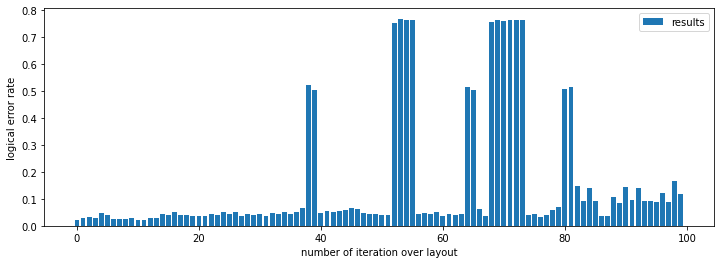

In [34]:
x = np.arange(len(aresults[:]))
plt.figure(figsize=(12.0,4.0))
plt.bar(x,aresults[:,1], label='results')
#plt.plot(aresults[:,2], linestyle='--', marker='o', label='average CNOT error')
plt.xlabel('number of iteration over layout')
plt.ylabel('logical error rate')
plt.legend()
plt.show()

In [ ]:
#################################### this block is for finding the optimal layout ##################################
sresults = sorted(results, key=itemgetter(1))
# Look at best cases
for i in range(10):
    print("Error rate is {} for layout no {}: {} with connectivity {}"\
          .format(sresults[i][1],  int(sresults[i][0]), layout_list[int(sresults[i][0])][0], layout_list[int(sresults[i][0])][1]))

In [ ]:
# load results from file
import numpy as np
qpu_results = np.loadtxt('BitFlipDetectionQPU2021-12-07.dat')
sim_results = np.loadtxt('BitFlipDetectionIBMSim2021-12-07.dat')
mysim_results = np.loadtxt('BitFlipDetectionMySim2021-12-07.dat')

sorted_sim_results = np.array(sorted(sim_results, key=itemgetter(1)))
sorted_mysim_results = np.array(sorted(mysim_results, key=itemgetter(1)))
sorted_qpu_results = np.array(sorted(qpu_results, key=itemgetter(1)))

In [ ]:
# make single array to compare performance and plot result
all_results = mysim_results[:,0:2]
all_results = np.append(all_results, qpu_results[:,1:2], axis=1)
all_results = np.append(all_results, sim_results[:,1:2], axis=1)
all_results = np.append(all_results, mysim_results[:,2:], axis=1)
all_results = np.array(sorted(all_results, key=itemgetter(1)))
all_results = all_results[0:20]

In [ ]:
# plot results 
x = np.arange(len(qpu_results[:]))

plt.figure(figsize=(12.0,3.0))
plt.xlabel('number of iteration over layout')
plt.ylabel('logical error rates')
plt.bar(x,qpu_results[:,1], label='logical error rate QPU', fc=(1, 0, 0, 0.5))
plt.bar(x,sim_results[:,1], label='logical error rate my model', fc=(0, 0, 1, 0.5))
plt.bar(x,mysim_results[:,1], label='logical error rate rate IBM model', fc=(0, 1, 0, 0.5))
plt.legend()
plt.show()

plt.figure(figsize=(12.0,3.0))
plt.bar(x,sim_results[:,2], label='average CNOT error')
plt.xlabel('number of iteration over layout')
plt.ylabel('average CNOT error')
plt.legend()
plt.show()

plt.figure(figsize=(12.0,3.0))
plt.bar(x,sim_results[:,3], label='average T2')
plt.xlabel('number of iteration over layout')
plt.ylabel('average T2')
plt.legend()
plt.show()

plt.figure(figsize=(12.0,3.0))
plt.bar(x,mysim_results[:,4], label='X Error')
plt.xlabel('number of iteration over layout')
plt.ylabel('X Error')
plt.legend()
plt.show()

plt.figure(figsize=(12.0,3.0))
plt.bar(x,mysim_results[:,5], label='Readout Error')
plt.xlabel('number of iteration over layout')
plt.ylabel('average readout error')
plt.legend()
plt.show()


In [ ]:
# plot results (optionally from file)
qpu_results = np.loadtxt('BitFlipDetectionQPUErrorQubit0_62021-12-21.dat')
sim_results = np.loadtxt('BitFlipDetectionMySimErrorQubit0_72021-12-21.dat')
#qpu_results = np.loadtxt('numerical_results/QPUResults/SydneyBitFlip_Qubit0_16Dez21/Results/averaged_results2021-12-20.dat')
#qpu_results = np.loadtxt('numerical_results/QPUResults/SydneyBitFlip_Qubit0_16Dez21/Results/BitFlipDetectionQPUErrorQubit0_52021-12-17.dat')

def plot_array(aresults):
    x = np.arange(len(aresults[:]))
    
    plt.figure(figsize=(12.0,4.0))
    plt.xlabel('number of iteration over layout')
    plt.ylabel('logical error rates')
    plt.bar(x,qpu_results[:,1], label='logical error rate qpu', fc=(1, 0, 0, 0.5))
    plt.bar(x,sim_results[:,1], label='logical error rate my simulator', fc=(0, 1, 0, 0.5))
    plt.bar(x,aresults[:,1], label='logical error rate IBM simulator', fc=(0, 0, 1, 0.5))
    #plt.bar(x,sortedsimresults[:,1], label='logical error IBM noise model', fc=(1, 0, 0, 0.5))
    plt.legend()
    plt.show()

    plt.figure(figsize=(12.0,4.0))
    plt.bar(x,aresults[:,2], label='average CNOT error')
    #plt.plot(aresults[:,2], linestyle='--', marker='o', label='average CNOT error')
    plt.xlabel('number of iteration over layout')
    plt.ylabel('average CNOT error')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12.0,4.0))
    plt.bar(x,aresults[:,3], label='average T2')
    #plt.plot(aresults[:,3], linestyle='--', marker='o', label='average T2')
    plt.xlabel('number of iteration over layout')
    plt.ylabel('average T2')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12.0,4.0))
    plt.bar(x,aresults[:,4], label='X Error')
    #plt.plot(aresults[:,4], linestyle='--', marker='o', label='average X Error')
    plt.xlabel('number of iteration over layout')
    plt.ylabel('X Error')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12.0,4.0))
    plt.bar(x,aresults[:,5], label='Readout Error')
    #plt.plot(aresults[:,4], linestyle='--', marker='o', label='average X Error')
    plt.xlabel('number of iteration over layout')
    plt.ylabel('average readout error')
    plt.legend()
    plt.show()
    
plot_array(aresults[:])

In [ ]:
# Look at best cases
for i in range(10):
    print("Error rate is {} for layout no {}: {} with connectivity {}"\
          .format(sresults[i][1],  int(sresults[i][0]), layout_list[int(sresults[i][0])][0], layout_list[int(sresults[i][0])][1]))

In [ ]:
# look at worst cases
for i in range(1,10):
    i *=-1
    print("Error rate is {} for layout no {}: {} with connectivity {}"\
          .format(sresults[i][1],  int(sresults[i][0]), layout_list[int(sresults[i][0])][0], layout_list[int(sresults[i][0])][1]))

Regel für die liste:

cnot zwischen 0->3, 1->3, 1->4, 2->4

initial_layout=[3, 4, 2] bedeutet: Virtual -> physical 0 -> 3 1 -> 4 2 -> 2

In [ ]:
original_layout_list = [11, 13, 14, 16, 19] 
nb_original_layout = 40
connectivity = [(11, 14), (13, 14), (14, 16), (16, 19)] 
permuts = list(itertools.permutations(original_layout_list))

In [ ]:
print(len(permuts))

In [ ]:
# loop over layout list and store result in list of dicts
permut_results = []

for l, layout in enumerate(permuts):
    tqc = transpile(qc, backend=simulator, basis_gates=basis_gates, \
                optimization_level=3, coupling_map=coupling_map, initial_layout=layout)
    result = simulator.run(tqc,shots=shots,memory=True).result()
    ancilla_counts = marginal_counts(result, indices=[0,1]).get_counts()

    # change to (01) for x[0], (11) for x[1], (10) for x[2]
    error_rate = 1.0-(ancilla_counts.get('01')/shots)

    results_ = [l,round(error_rate,5)]
    results_ += characterize_initial_layout(initial_layout=layout,initial_coupling=connectivity)
    results_.append(tqc.depth())
    results_.append(tqc.count_ops()['cx'])
    results_.append(tqc.size())

    permut_results.append(results_)

In [ ]:
# sort by value
spermut_results = sorted(permut_results, key=itemgetter(1))
spermut_results = np.array(spermut_results)
apermut_results = np.array(permut_results)

In [ ]:
# plot results (optionally from file)

#aresults = np.loadtxt('predef_layout_2021-11-04.dat')
#aresults = [sublist[:-1] for sublist in results]
x = np.arange(len(spermut_results))

def plot_array(aresults):
    plt.figure(figsize=(12.0,4.0))
    plt.xlabel('number of iteration over layout')
    plt.ylabel('logical error rates')
    #plt.plot(aresults[:,2], linestyle='--', marker='o', label='average CNOT error')
    plt.bar(x,aresults[:,1], label='logical error rate')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12.0,4.0))
    plt.bar(x,aresults[:,6], label='depth of compiled circuit')
    #plt.plot(aresults[:,4], linestyle='--', marker='o', label='average X Error')
    plt.xlabel('number of iteration over layout')
    plt.ylabel('depth of compiled circuit')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12.0,4.0))
    plt.bar(x,aresults[:,7], label='no cnots of compiled circuit')
    #plt.plot(aresults[:,4], linestyle='--', marker='o', label='average X Error')
    plt.xlabel('number of iteration over layout')
    plt.ylabel('no cnots of compiled circuit')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12.0,4.0))
    plt.bar(x,aresults[:,8], label='size of compiled circuit')
    #plt.plot(aresults[:,4], linestyle='--', marker='o', label='average X Error')
    plt.xlabel('number of iteration over layout')
    plt.ylabel('size of compiled circuit')
    plt.legend()
    plt.show()
    
plot_array(spermut_results)

In [ ]:
# Look at best cases
for i in range(10):
    print("Error rate is {} for layout no {}: {}"\
          .format(spermut_results[i][1],  int(spermut_results[i][0]), permuts[int(spermut_results[i][0])]))

In [ ]:
# sort by lowerst cnot
spermut_results = sorted(permut_results, key=itemgetter(7))

In [ ]:
# [(11, 14), (13, 14), (14, 16), (16, 19)] 
for i in range(10):
    print("Error rate is {} for layoutnb {}, cnot nb {}: {}"\
          .format(spermut_results[i][1],  int(spermut_results[i][0]), spermut_results[i][7], permuts[int(spermut_results[i][0])]))

In [ ]:
# schreibe bitflip code so, dass ich zu Beginn selbst die benötigten Swaps für die CNOTs ausführe.
# Look at best cases
for i in range(10):
    print("Error rate is {} for layout no {}: {} with connectivity {}"\
          .format(sresults[i][1],  int(sresults[i][0]), layout_list[int(sresults[i][0])][0], layout_list[int(sresults[i][0])][1]))

In [ ]:
simulator = AerSimulator(noise_model=my_noise_model)
qc = bitflip_code_only_detection_with_cat_state(pos_xerror=0)
tqc = transpile(qc, backend=simulator, basis_gates=basis_gates, \
                optimization_level=3, coupling_map=coupling_map, initial_layout=(9, 11, 13, 8, 14))
tqc.count_ops()

In [ ]:
display(plot_circuit_layout(tqc, backend)) 

In [ ]:
tqc.draw('mpl', idle_wires=False)

In [ ]:
result = simulator.run(tqc, shots=1000000, memory=True).result()
projection_counts = marginal_counts(result, indices=[0,1]).get_counts()
ancilla_counts = result.get_counts()['01 00']
error_rate = 1-(ancilla_counts/projection_counts['00'])

In [ ]:
error_rate

In [ ]:
print(layout_list[int(sresults[0][0])][0])

In [ ]:
print(sresults[1][2])

In [ ]:
e=6
print(layout_list[int(sresults[e][0])][0])
for el in layout_list[int(sresults[e][0])][1]:
    print(properties.gate_error('cx',el))
print("\n")
print(properties.readout_error(layout_list[int(sresults[e][0])][0][-1]))
print(properties.readout_error(layout_list[int(sresults[e][0])][0][-2]))

In [ ]:

qc = bitflip_code_only_detection()
tqc = transpile(qc, backend=simulator, basis_gates=basis_gates, \
                optimization_level=3, coupling_map=coupling_map, initial_layout=(11, 13, 19, 14, 16))
display(plot_circuit_layout(tqc, backend))    

In [ ]:
il = [11, 13, 19, 14, 16]
connectivity_list = [(11, 14), (13, 14), (14, 16), (16, 19)] 
cnot_gate_list = [(il[0],il[3]),(il[1],il[3]),(il[1],il[4]),(il[2],il[4])]

In [ ]:
cnot_gate_list= [(11, 14), (13, 14), (14, 16), (16, 19)] 

In [ ]:
counter = 0
for t, tuple in enumerate(connectivity_list):
    if ((tuple==cnot_gate_list[t]) or ((tuple[1],tuple[0])==cnot_gate_list[t])):
        counter+=1

In [ ]:
counter

In [ ]:
result = [do_something_with(item) for item in item_list]

In [ ]:
# find all connected subgraphs in coupling map
G = nx.Graph()
G.add_nodes_from(list(np.arange(27)))
G.add_edges_from(coupling_map)

all_connected_subgraphs = []
layout_list = []
nb_nodes=5
for SG in (G.subgraph(selected_nodes) for selected_nodes in combinations(G, nb_nodes)):
    if nx.is_connected(SG):
        #print(SG.nodes)
        all_connected_subgraphs.append(SG)
        layout_list.append([list(SG.nodes),list(SG.edges)])

In [ ]:
lalist = [item[0] for item in layout_list]

In [ ]:
cnot_layout_list = []
for item in layout_list:
    permuts = list(itertools.permutations(item[0]))
    for permut in permuts:
        cnot_gate_list = [(permut[0],permut[3]),(permut[1],permut[3]),(permut[1],permut[4]),(permut[2],permut[4])]
        counter_cnots = 0
        for t, tuple in enumerate(item[1]):
            if ((tuple==cnot_gate_list[t]) or ((tuple[1],tuple[0])==cnot_gate_list[t])):
                counter_cnots+=1
            if counter_cnots>=4:
                cnot_layout_list.append([permut,item[1]])

In [ ]:
len(cnot_layout_list)

In [ ]:
simulator = AerSimulator(noise_model=noise_model)
qc = bitflip_code_only_detection()
tqc = transpile(qc, backend=simulator, basis_gates=basis_gates, \
                optimization_level=3, coupling_map=coupling_map, initial_layout=cnot_layout_list[20][0])
display(tqc.draw('mpl', idle_wires=False))
display(plot_circuit_layout(tqc, backend))  

In [ ]:
tqc.count_ops()

In [ ]:
from qiskit.visualization import plot_gate_map
plot_gate_map(backend)

In [ ]:
# plot results in tight layout (optionally from file)

#aresults = np.loadtxt('predef_layout_2021-11-04.dat')
#aresults = [sublist[:-1] for sublist in results]

plt.figure(figsize=(12.0,4.0))
plt.subplot(1,4,1)
plt.xlabel('number of iteration over layout')
plt.ylabel('effective error rates')
plt.plot(aresults[:,0],aresults[:,1], linestyle='--', marker='o', label='logical error rate')
plt.legend()
plt.subplot(1,4,2)
plt.plot(aresults[:,0],aresults[:,2], linestyle='--', marker='o', label='average CNOT error')
plt.xlabel('number of iteration over layout')
plt.ylabel('average CNOT error')
plt.legend()
plt.subplot(1,4,3)
plt.plot(aresults[:,0],aresults[:,3], linestyle='--', marker='o', label='average T2')
plt.xlabel('number of iteration over layout')
plt.ylabel('average T2')
plt.legend()
plt.subplot(1,4,4)
plt.plot(aresults[:,0],aresults[:,4], linestyle='--', marker='o', label='average X Error')
plt.xlabel('number of iteration over layout')
plt.ylabel('average X Error')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# plot results (optionally from file)

#aresults = np.loadtxt('predef_layout_2021-11-04.dat')
#aresults = [sublist[:-1] for sublist in results]
x = np.arange(len(aresults))

def plot_array(aresults):
    plt.figure(figsize=(12.0,4.0))
    plt.bar(x,aresults[:,6], label='depth of compiled circuit')
    #plt.plot(aresults[:,4], linestyle='--', marker='o', label='average X Error')
    plt.xlabel('number of iteration over layout')
    plt.ylabel('depth of compiled circuit')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12.0,4.0))
    plt.bar(x,aresults[:,7], label='no cnots of compiled circuit')
    #plt.plot(aresults[:,4], linestyle='--', marker='o', label='average X Error')
    plt.xlabel('number of iteration over layout')
    plt.ylabel('no cnots of compiled circuit')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12.0,4.0))
    plt.bar(x,aresults[:,8], label='size of compiled circuit')
    #plt.plot(aresults[:,4], linestyle='--', marker='o', label='average X Error')
    plt.xlabel('number of iteration over layout')
    plt.ylabel('size of compiled circuit')
    plt.legend()
    plt.show()
    
plot_array(sresults)